In [5]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

CUDA available: True
Device: cuda


In [6]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import rasterio
import albumentations as A
import timm
from tqdm import tqdm
import csv
from torch.cuda.amp import autocast, GradScaler

In [7]:
class CloudDataset(Dataset):
    def __init__(self, metadata, root_dir, transform=None):
        self.metadata = metadata
        self.root_dir = root_dir
        self.transform = transform
        self.feature_dir = os.path.join(root_dir, 'train_features')
        self.label_dir = os.path.join(root_dir, 'train_labels')

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        chip_id = self.metadata.iloc[idx]['chip_id']
        feature_path = os.path.join(self.feature_dir, chip_id)
        label_path = os.path.join(self.label_dir, f"{chip_id}.tif")

        bands = ['B02', 'B03', 'B04', 'B08']
        features = []

        for band in bands:
            with rasterio.open(os.path.join(feature_path, f'{band}.tif')) as src:
                features.append(src.read(1).astype(np.float32))

        image = np.stack(features, axis=-1)

        with rasterio.open(label_path) as src:
            mask = src.read(1).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = torch.from_numpy(image).permute(2, 0, 1).float()
        mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image, mask

In [8]:
mean_vals = (0.5, 0.5, 0.5, 0.5)
std_vals = (0.5, 0.5, 0.5, 0.5)

train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=mean_vals, std=std_vals, max_pixel_value=65535.0),
], additional_targets={'mask': 'mask'})

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=mean_vals, std=std_vals, max_pixel_value=65535.0),
], additional_targets={'mask': 'mask'})


In [9]:
root_dir = 'data'
metadata = pd.read_csv('data/train_metadata.csv')

train_meta, temp_meta = train_test_split(metadata, test_size=0.3, random_state=42)
val_meta, test_meta = train_test_split(temp_meta, test_size=2/3, random_state=42)


In [10]:
train_dataset = CloudDataset(train_meta, root_dir, train_transform)
val_dataset   = CloudDataset(val_meta, root_dir, val_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))


Train samples: 8223
Val samples: 1175


In [11]:
class XceptionBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model(
            'xception41', pretrained=True, features_only=True, in_chans=4
        )

    def forward(self, x):
        features = self.model(x)
        return features[1], features[3]
class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)
class ImprovedDeepLabV3Plus(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = XceptionBackbone()
        self.aspp = ASPP(1024, 256)
        self.final = nn.Conv2d(256, 1, 1)

    def forward(self, x):
        h, w = x.shape[-2:]
        low, high = self.backbone(x)
        x = self.aspp(high)
        x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=False)
        return torch.sigmoid(self.final(x))


In [12]:
class DiceLoss(nn.Module):
    def forward(self, pred, target):
        smooth = 1.
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        return 1 - (2.*intersection + smooth)/(pred.sum()+target.sum()+smooth)
def compute_iou(pred, target):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection / (union + 1e-6)).item()

In [13]:
def compute_metrics(pred, target, threshold=0.5):
    pred = (pred > threshold).float()

    TP = (pred * target).sum()
    TN = ((1 - pred) * (1 - target)).sum()
    FP = (pred * (1 - target)).sum()
    FN = ((1 - pred) * target).sum()

    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-6)
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    iou = TP / (TP + FP + FN + 1e-6)

    return accuracy.item(), precision.item(), recall.item(), iou.item()


In [14]:
from torch.amp import autocast, GradScaler
import csv

def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=50,
    patience=50
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

    # ✅ AMP-SAFE LOSS
    bce_loss = nn.BCEWithLogitsLoss()
    criterion = lambda p, t: (
        0.5 * bce_loss(p, t) +
        0.5 * DiceLoss()(torch.sigmoid(p), t)
    )

    scaler = GradScaler("cuda")
    best_val_loss = float('inf')
    epochs_no_improve = 0

    with open("training_results2.csv", "w", newline="") as f:
        writer = csv.DictWriter(
            f,
            fieldnames=[
                "epoch", "train_loss", "val_loss",
                "accuracy", "precision", "recall", "iou"
            ]
        )
        writer.writeheader()

        for epoch in range(num_epochs):
            # ---------- TRAIN ----------
            model.train()
            train_loss = 0.0
            acc = prec = rec = iou = 0.0

            for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                imgs, masks = imgs.to(device), masks.to(device)
                optimizer.zero_grad()

                with autocast(device_type="cuda"):
                    preds = model(imgs)          # logits
                    loss = criterion(preds, masks)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                train_loss += loss.item()

                # Metrics use probabilities
                probs = torch.sigmoid(preds)
                a, p, r, i = compute_metrics(probs, masks)
                acc += a; prec += p; rec += r; iou += i

            train_loss /= len(train_loader)
            acc /= len(train_loader)
            prec /= len(train_loader)
            rec /= len(train_loader)
            iou /= len(train_loader)

            # ---------- VALIDATION ----------
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for imgs, masks in val_loader:
                    imgs, masks = imgs.to(device), masks.to(device)
                    preds = model(imgs)
                    val_loss += criterion(preds, masks).item()

            val_loss /= len(val_loader)

            writer.writerow({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "iou": iou
            })
            f.flush()

            scheduler.step()

            print(
                f"Epoch {epoch+1}: "
                f"Train={train_loss:.4f}, Val={val_loss:.4f}, IoU={iou:.4f}"
            )

            # ---------- EARLY STOPPING ----------
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), "final1_model2.pth")
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print("⛔ Early stopping triggered")
                    break

In [11]:
model = ImprovedDeepLabV3Plus()
train_model(model, train_loader, val_loader, num_epochs=50)

Epoch 1/50: 100%|██████████████████████████████████████████████████████████████████| 2056/2056 [08:01<00:00,  4.27it/s]


Epoch 1: Train=0.4475, Val=0.4162, IoU=0.6743


Epoch 2/50: 100%|██████████████████████████████████████████████████████████████████| 2056/2056 [08:06<00:00,  4.22it/s]


Epoch 2: Train=0.4362, Val=0.4109, IoU=0.7220


Epoch 3/50: 100%|██████████████████████████████████████████████████████████████████| 2056/2056 [08:07<00:00,  4.22it/s]


Epoch 3: Train=0.4328, Val=0.4125, IoU=0.7541


Epoch 4/50: 100%|██████████████████████████████████████████████████████████████████| 2056/2056 [08:06<00:00,  4.22it/s]


Epoch 4: Train=0.4311, Val=0.4108, IoU=0.7733


Epoch 5/50: 100%|██████████████████████████████████████████████████████████████████| 2056/2056 [08:06<00:00,  4.23it/s]


Epoch 5: Train=0.4318, Val=0.4098, IoU=0.7760


Epoch 6/50: 100%|██████████████████████████████████████████████████████████████████| 2056/2056 [08:06<00:00,  4.22it/s]


Epoch 6: Train=0.4310, Val=0.4087, IoU=0.7837


Epoch 7/50: 100%|██████████████████████████████████████████████████████████████████| 2056/2056 [08:05<00:00,  4.23it/s]


Epoch 7: Train=0.4306, Val=0.4095, IoU=0.7851


Epoch 8/50: 100%|██████████████████████████████████████████████████████████████████| 2056/2056 [08:06<00:00,  4.22it/s]


Epoch 8: Train=0.4295, Val=0.4098, IoU=0.7884


Epoch 9/50: 100%|██████████████████████████████████████████████████████████████████| 2056/2056 [08:05<00:00,  4.24it/s]


Epoch 9: Train=0.4296, Val=0.4093, IoU=0.7885


Epoch 10/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:05<00:00,  4.23it/s]


Epoch 10: Train=0.4293, Val=0.4114, IoU=0.7926


Epoch 11/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:05<00:00,  4.23it/s]


Epoch 11: Train=0.4301, Val=0.4086, IoU=0.7912


Epoch 12/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:04<00:00,  4.24it/s]


Epoch 12: Train=0.4302, Val=0.4087, IoU=0.7930


Epoch 13/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:04<00:00,  4.25it/s]


Epoch 13: Train=0.4297, Val=0.4087, IoU=0.7943


Epoch 14/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:05<00:00,  4.24it/s]


Epoch 14: Train=0.4290, Val=0.4093, IoU=0.7921


Epoch 15/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:04<00:00,  4.24it/s]


Epoch 15: Train=0.4278, Val=0.4086, IoU=0.8001


Epoch 16/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:05<00:00,  4.24it/s]


Epoch 16: Train=0.4279, Val=0.4086, IoU=0.8015


Epoch 17/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:05<00:00,  4.24it/s]


Epoch 17: Train=0.4282, Val=0.4083, IoU=0.7995


Epoch 18/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:04<00:00,  4.24it/s]


Epoch 18: Train=0.4275, Val=0.4073, IoU=0.8031


Epoch 19/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:05<00:00,  4.24it/s]


Epoch 19: Train=0.4297, Val=0.4110, IoU=0.7967


Epoch 20/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:05<00:00,  4.24it/s]


Epoch 20: Train=0.4291, Val=0.4105, IoU=0.7983


Epoch 21/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:05<00:00,  4.24it/s]


Epoch 21: Train=0.4282, Val=0.4082, IoU=0.8005


Epoch 22/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:05<00:00,  4.24it/s]


Epoch 22: Train=0.4276, Val=0.4086, IoU=0.8044


Epoch 23/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:05<00:00,  4.24it/s]


Epoch 23: Train=0.4286, Val=0.4098, IoU=0.8005


Epoch 24/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:04<00:00,  4.24it/s]


Epoch 24: Train=0.4282, Val=0.4097, IoU=0.8028


Epoch 25/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:05<00:00,  4.24it/s]


Epoch 25: Train=0.4268, Val=0.4113, IoU=0.8052


Epoch 26/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:02<00:00,  4.26it/s]


Epoch 26: Train=0.4261, Val=0.4075, IoU=0.8064


Epoch 27/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:03<00:00,  4.26it/s]


Epoch 27: Train=0.4283, Val=0.4094, IoU=0.8013


Epoch 28/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:03<00:00,  4.26it/s]


Epoch 28: Train=0.4278, Val=0.4090, IoU=0.8030


Epoch 29/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:02<00:00,  4.26it/s]


Epoch 29: Train=0.4273, Val=0.4112, IoU=0.8054


Epoch 30/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:03<00:00,  4.25it/s]


Epoch 30: Train=0.4277, Val=0.4091, IoU=0.8026


Epoch 31/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:04<00:00,  4.25it/s]


Epoch 31: Train=0.4271, Val=0.4102, IoU=0.8054


Epoch 32/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:03<00:00,  4.25it/s]


Epoch 32: Train=0.4263, Val=0.4091, IoU=0.8092


Epoch 33/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:03<00:00,  4.25it/s]


Epoch 33: Train=0.4268, Val=0.4103, IoU=0.8061


Epoch 34/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:03<00:00,  4.25it/s]


Epoch 34: Train=0.4275, Val=0.4099, IoU=0.8035


Epoch 35/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:02<00:00,  4.26it/s]


Epoch 35: Train=0.4258, Val=0.4096, IoU=0.8097


Epoch 36/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:02<00:00,  4.26it/s]


Epoch 36: Train=0.4251, Val=0.4082, IoU=0.8122


Epoch 37/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:02<00:00,  4.26it/s]


Epoch 37: Train=0.4265, Val=0.4119, IoU=0.8078


Epoch 38/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:03<00:00,  4.26it/s]


Epoch 38: Train=0.4251, Val=0.4181, IoU=0.8129


Epoch 39/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:03<00:00,  4.26it/s]


Epoch 39: Train=0.4246, Val=0.4107, IoU=0.8133


Epoch 40/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:02<00:00,  4.26it/s]


Epoch 40: Train=0.4265, Val=0.4124, IoU=0.8087


Epoch 41/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:02<00:00,  4.26it/s]


Epoch 41: Train=0.4267, Val=0.4125, IoU=0.8073


Epoch 42/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:03<00:00,  4.26it/s]


Epoch 42: Train=0.4270, Val=0.4145, IoU=0.8072


Epoch 43/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:02<00:00,  4.26it/s]


Epoch 43: Train=0.4243, Val=0.4143, IoU=0.8157


Epoch 44/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:02<00:00,  4.26it/s]


Epoch 44: Train=0.4269, Val=0.4139, IoU=0.8064


Epoch 45/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:04<00:00,  4.24it/s]


Epoch 45: Train=0.4247, Val=0.4132, IoU=0.8140


Epoch 46/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:03<00:00,  4.25it/s]


Epoch 46: Train=0.4265, Val=0.4123, IoU=0.8092


Epoch 47/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:03<00:00,  4.26it/s]


Epoch 47: Train=0.4258, Val=0.4154, IoU=0.8114


Epoch 48/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:02<00:00,  4.26it/s]


Epoch 48: Train=0.4246, Val=0.4144, IoU=0.8142


Epoch 49/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:02<00:00,  4.26it/s]


Epoch 49: Train=0.4256, Val=0.4112, IoU=0.8106


Epoch 50/50: 100%|█████████████████████████████████████████████████████████████████| 2056/2056 [08:03<00:00,  4.26it/s]


Epoch 50: Train=0.4258, Val=0.4140, IoU=0.8102


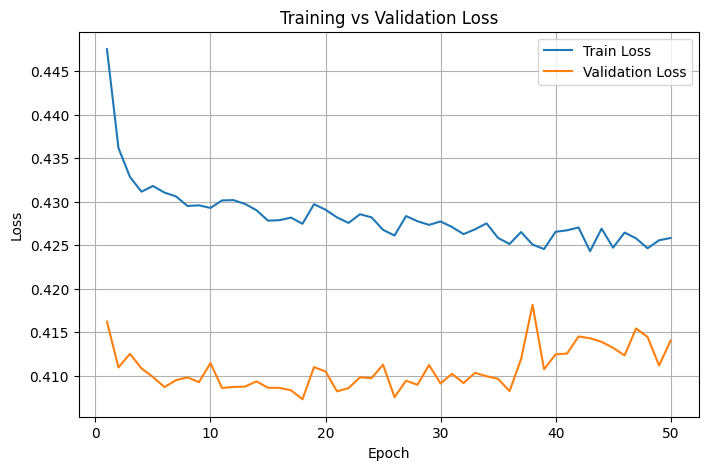

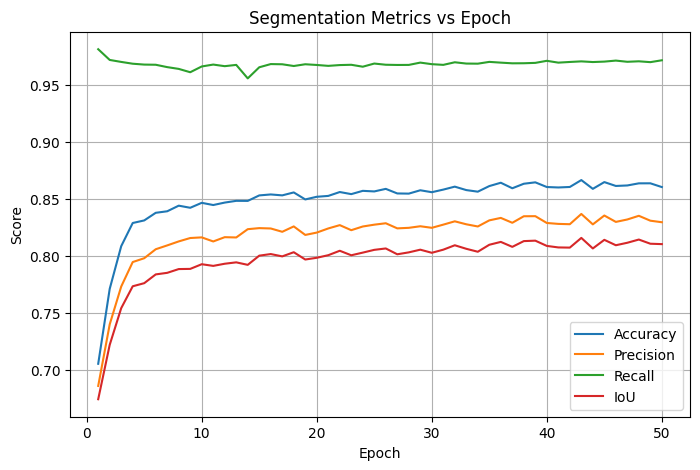

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("training_results2.csv")

# ---------- LOSS PLOT ----------
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["train_loss"], label="Train Loss")
plt.plot(df["epoch"], df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---------- METRICS PLOT ----------
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["accuracy"], label="Accuracy")
plt.plot(df["epoch"], df["precision"], label="Precision")
plt.plot(df["epoch"], df["recall"], label="Recall")
plt.plot(df["epoch"], df["iou"], label="IoU")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Segmentation Metrics vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

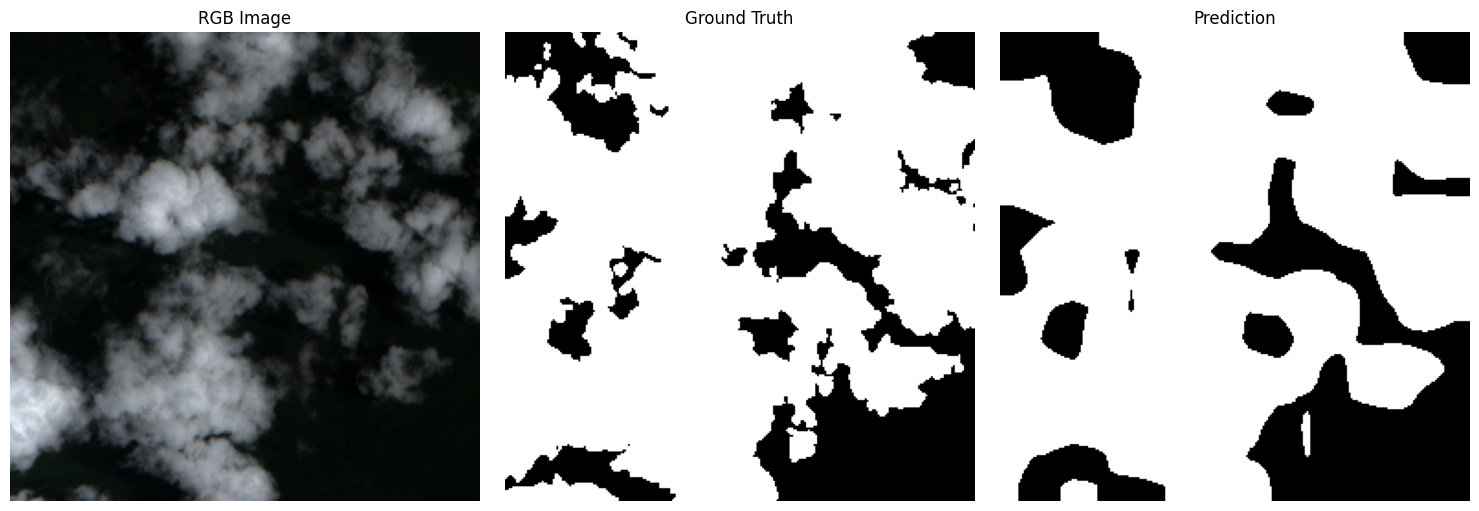

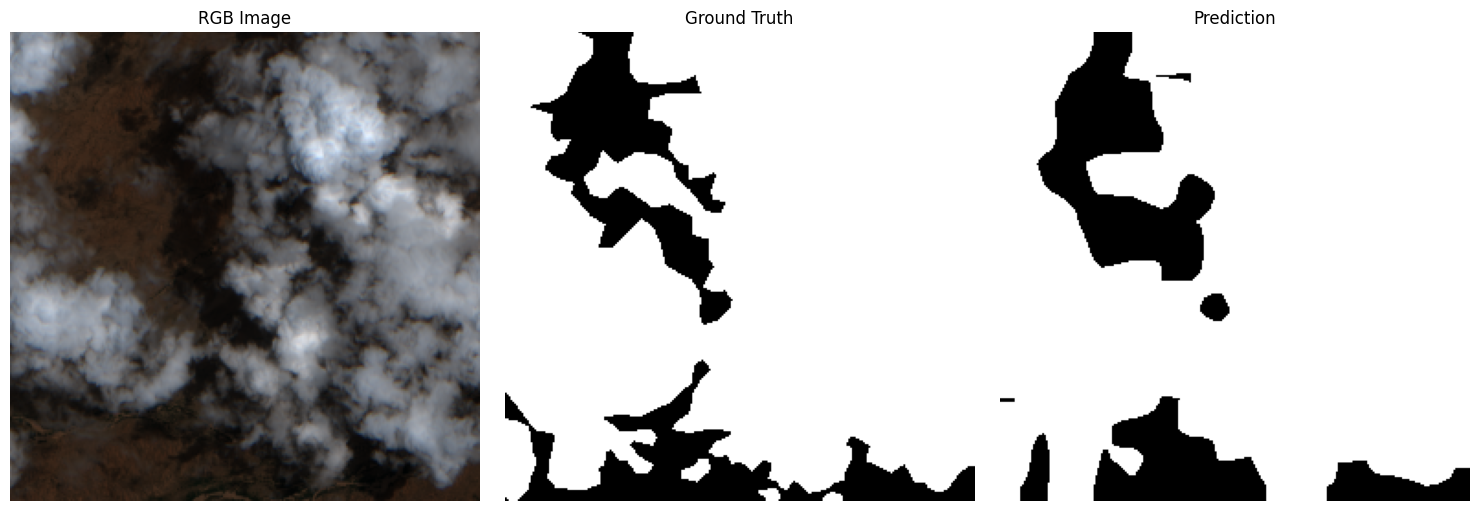

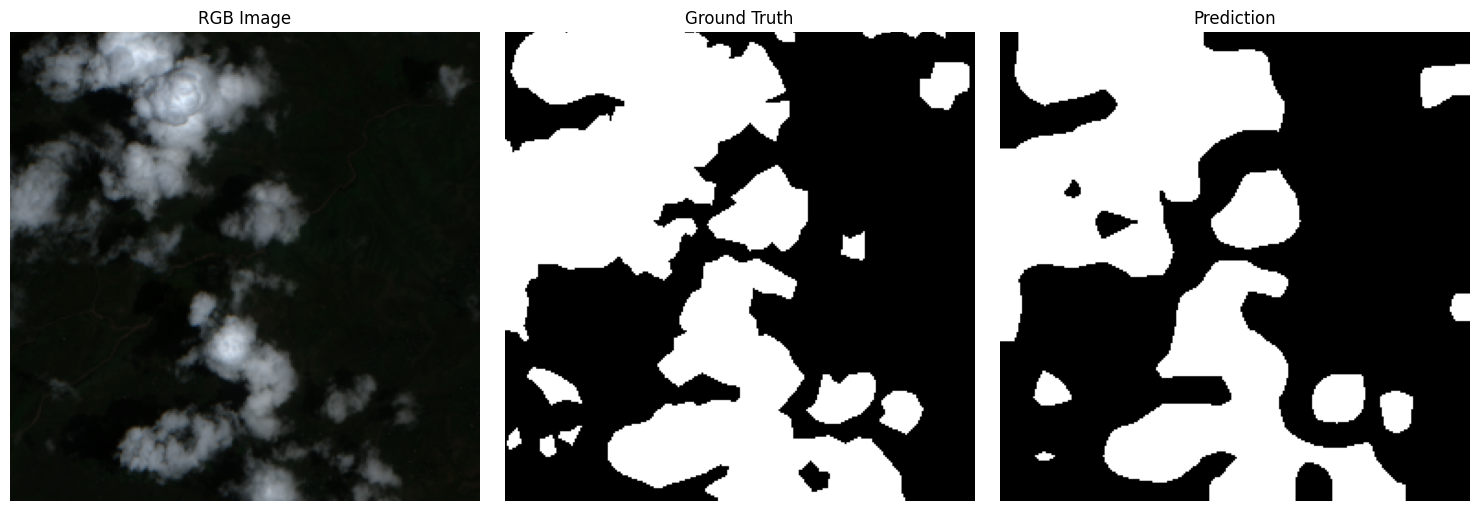

In [21]:
import random

num_images = 3
indices = random.sample(range(len(val_dataset)), num_images)

with torch.no_grad():
    for idx in indices:
        image, mask = val_dataset[idx]

        image = image.unsqueeze(0).to(device)
        mask = mask.unsqueeze(0).to(device)

        output = model(image)
        pred = (output > 0.5).float()

        img = image[0].cpu().numpy()
        gt = mask[0][0].cpu().numpy()
        pr = pred[0][0].cpu().numpy()

        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        rgb = img[[2, 1, 0], :, :].transpose(1, 2, 0)

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(rgb)
        axs[0].set_title("RGB Image")

        axs[1].imshow(gt, cmap="gray")
        axs[1].set_title("Ground Truth")

        axs[2].imshow(pr, cmap="gray")
        axs[2].set_title("Prediction")

        for ax in axs:
            ax.axis("off")

        plt.tight_layout()
        plt.show()
